In [1]:
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import *
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark import ml
import config
import os
import numpy as np
import pandas as pd
import seaborn
import plotly.express as px
import plotly
import sklearn.metrics
seaborn.set(color_codes = True)
import importlib
import custom_transformer

spark = SparkSession.builder.appName("Train SVM")\
    .config("spark.executor.memory","4g")\
    .config("spark.driver.memory","5g")\
    .master('local[24]')\
    .getOrCreate()

In [2]:
field_names = ['label','text','rand']
field_types = [T.IntegerType(), T.StringType(), T.FloatType()]

training_schema = T.StructType([
    T.StructField(field_name, field_type, True) for field_name, field_type in zip(field_names, field_types)
])

test_data = spark.read.load(os.path.join(config.DATA_DIR, 'emojified_test.csv'), format = 'csv', sep = ',', 
                            schema = training_schema, header = True).drop('rand')

In [3]:
validation_data = tweets = spark.read.load(os.path.join(config.DATA_DIR, 'validation.csv'), format = 'csv', sep = ',', schema = config.TWEET_DB_SCHEMA)

validation_data = validation_data.select(
    (F.col('label')/2).cast(T.IntegerType()).alias('trinary_label'), 
    F.when(validation_data['label']==4, 1).otherwise(0).alias('positive_binary'),
    F.when(validation_data['label']==0, 0).otherwise(1).alias('negative_binary'),
    F.col('text')    
)

validation_data.show()

+-------------+---------------+---------------+--------------------+
|trinary_label|positive_binary|negative_binary|                text|
+-------------+---------------+---------------+--------------------+
|            2|              1|              1|@stellargirl I lo...|
|            2|              1|              1|Reading my kindle...|
|            2|              1|              1|Ok, first assesme...|
|            2|              1|              1|@kenburbary You'l...|
|            2|              1|              1|@mikefish  Fair e...|
|            2|              1|              1|@richardebaker no...|
|            0|              0|              0|Fuck this economy...|
|            2|              1|              1|Jquery is my new ...|
|            2|              1|              1|       Loves twitter|
|            2|              1|              1|how can you not l...|
|            1|              0|              1|Check this video ...|
|            0|              0|   

In [4]:
model = ml.PipelineModel.load('LR_with_emoji_pipeline')

In [5]:
predictions = model.transform(validation_data)\
    .select('trinary_label','positive_binary','negative_binary', 'text','probability','prediction').toPandas()

predictions['probability'] = predictions.probability.apply(lambda x : x[1])

In [9]:
#1. positive pooling ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(predictions.positive_binary, predictions.probability)
thresholds[0] = 1.0
fig = plotly.graph_objs.Figure()
fig.add_trace(dict(
    type = 'scatter',
    x = fpr,
    y = tpr,
    text=thresholds,
    name = 'positive vs. neutral & negative'
))

#2. negative pooling ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(predictions.negative_binary, predictions.probability)
thresholds[0] = 1.0
fig.add_trace(dict(
    type = 'scatter',
    x = fpr,
    y = tpr,
    text=thresholds,
    name = 'negative vs. neutral & positive'
))

no_neutrals = predictions[predictions.trinary_label != 1]
no_neutrals['binary_label_no_netural'] = no_neutrals.trinary_label//2

fpr, tpr, thresholds = sklearn.metrics.roc_curve(no_neutrals.binary_label_no_netural, no_neutrals.probability)
thresholds[0] = 1.0
fig.add_trace(dict(
    type = 'scatter',
    x = fpr,
    y = tpr,
    text=thresholds,
    name = 'negative vs. positive'
))
#fig.write_image('ROC.svg')
fig.show()

C:\Users\allen\Anaconda3\envs\sparkapp\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
def convert_to_trinary(prob, t1, t2):
    return (prob > t1).astype(np.int) + (prob > t2).astype(np.int)

def calc_metric(label, prediction):
    return sklearn.metrics.f1_score(label, prediction, average = 'macro')

def get_multiclass_F1(df, t1, t2):
    return calc_metric(df.trinary_label, convert_to_trinary(df.probability, t1, t2))

In [18]:
#grid search
f1_scores = []
for t1 in np.arange(0.0, 0.51, 0.01):
    for t2 in np.arange(0.5, 1.0, 0.01):
        f1_scores.append((t1, t2, get_multiclass_F1(predictions, t1, t2)))

f1_df = pd.DataFrame(f1_scores, columns = ['T1','T2','F1'])

In [24]:
f1_df.sort_values('F1', ascending = False).iloc[0]

T1    0.410000
T2    0.710000
F1    0.583133
Name: 2071, dtype: float64

In [36]:
#custom_transformer = importlib.reload(custom_transformer)
label_transformer = custom_transformer.ProbabilityToLabel(
    inputCol = 'probability', outputCol = 'trinary_prediction')\
    .setParams(negativeThreshold = 0.41, positiveThreshold = 0.71)

full_pipe = ml.PipelineModel(stages=[model, label_transformer])

output = full_pipe.transform(validation_data)

predictions = output.select('trinary_label','trinary_prediction').toPandas()

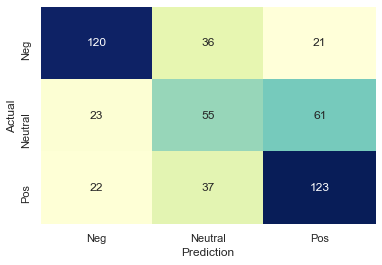

In [37]:
confusion_matrix = sklearn.metrics.confusion_matrix(predictions['trinary_label'], predictions['trinary_prediction'])

ax = seaborn.heatmap(confusion_matrix, annot = confusion_matrix, fmt = 'd', cmap="YlGnBu", cbar = False,
            xticklabels = ['Neg','Neutral','Pos'], yticklabels = ['Neg','Neutral','Pos'])

ax.set(xlabel='Prediction', ylabel='Actual')

fig = ax.get_figure()

fig.savefig('confusion_matrix.png')

In [38]:
full_pipe.save('stream_ready_pipeline')